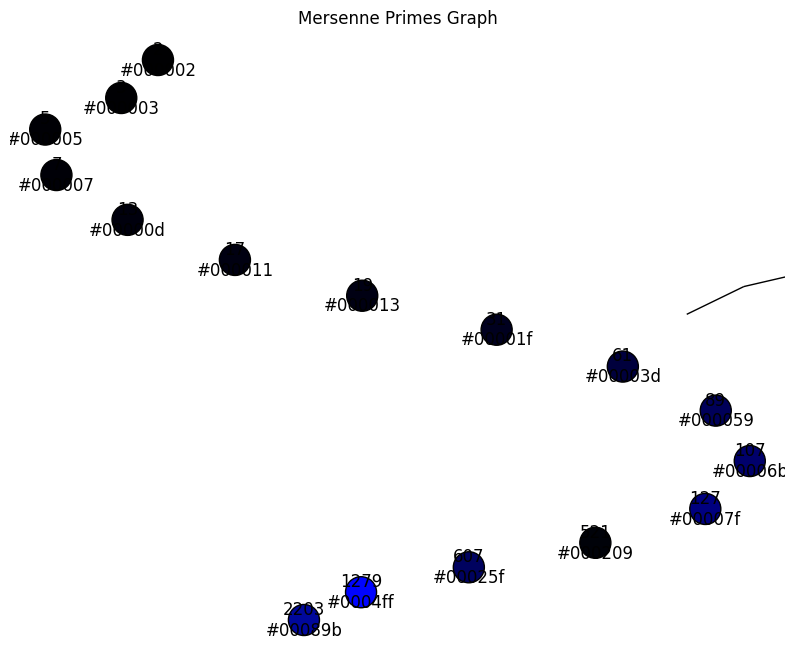

Extracted Patterns: defaultdict(<class 'list'>, {'difference': [1, 2, 2, 6, 4, 2, 12, 30, 28, 18, 20, 394, 86, 672, 924], 'ratio': [1.5, 1.6666666666666667, 1.4, 1.8571428571428572, 1.3076923076923077, 1.1176470588235294, 1.631578947368421, 1.967741935483871, 1.459016393442623, 1.202247191011236, 1.1869158878504673, 4.102362204724409, 1.165067178502879, 2.1070840197693577, 1.7224394057857702]})
Epoch 0/50, Loss: 96837.4922
Epoch 10/50, Loss: 91576.0156
Epoch 20/50, Loss: 86551.2422
Epoch 30/50, Loss: 81648.4453
Epoch 40/50, Loss: 76967.8594
Predicted Next Mersenne Prime (Approx): 2551


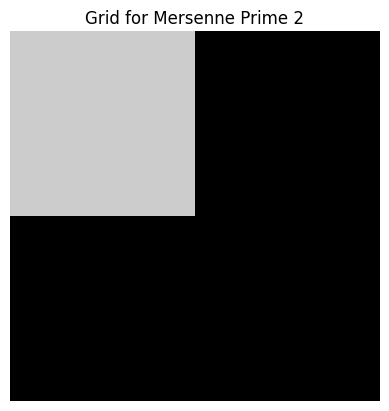

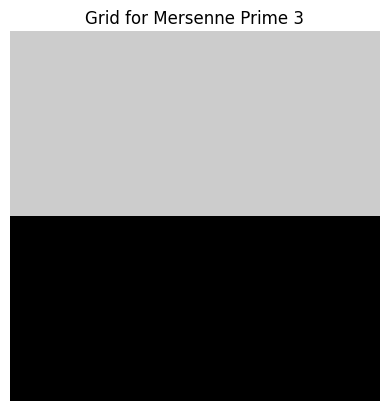

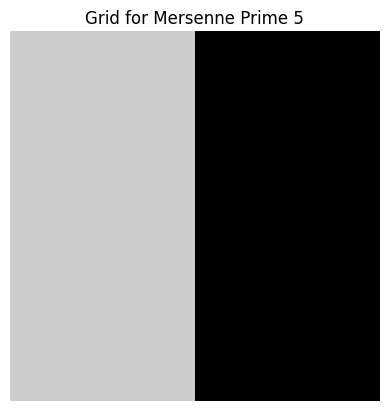

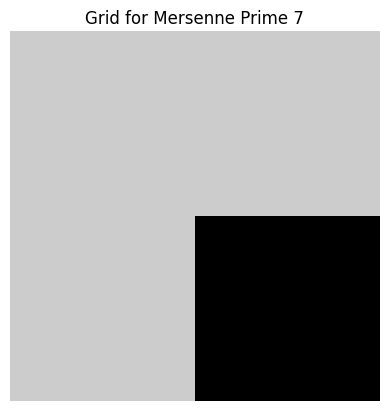

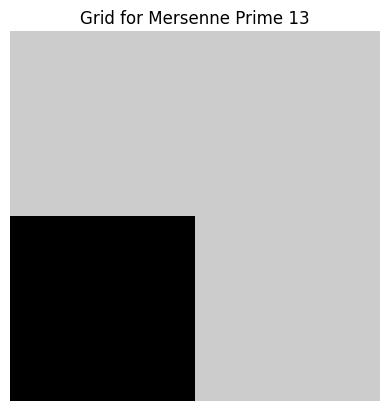

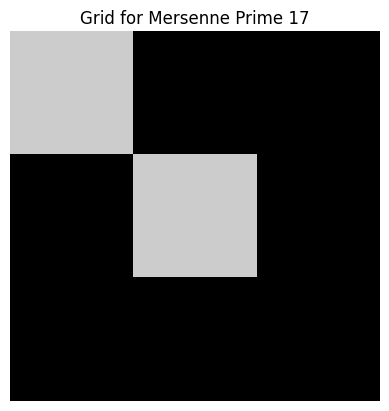

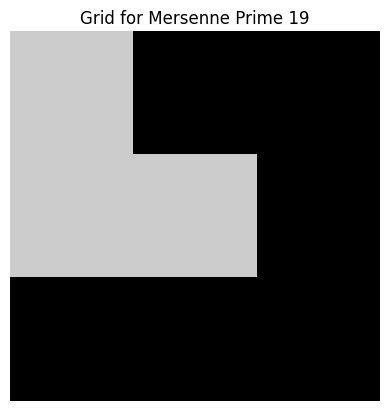

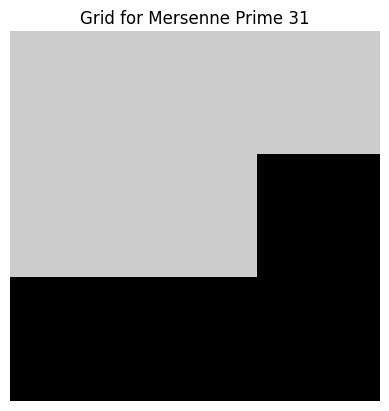

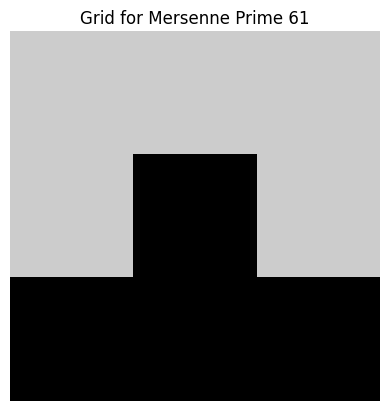

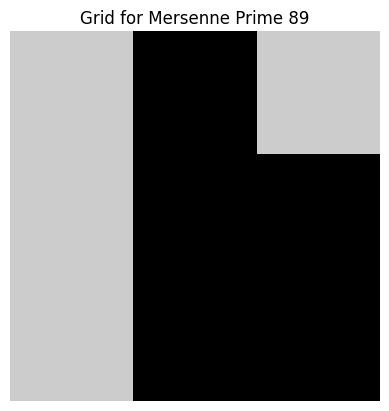

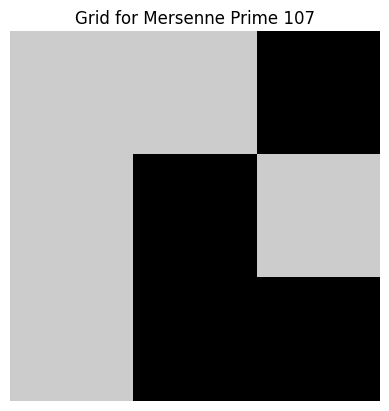

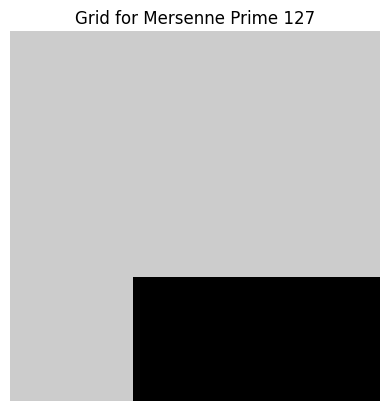

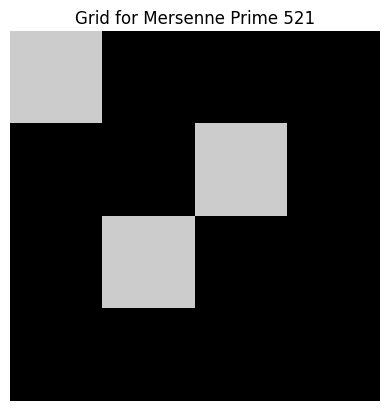

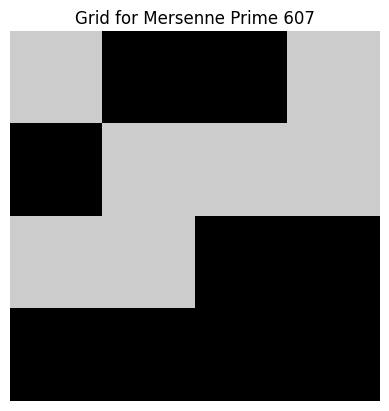

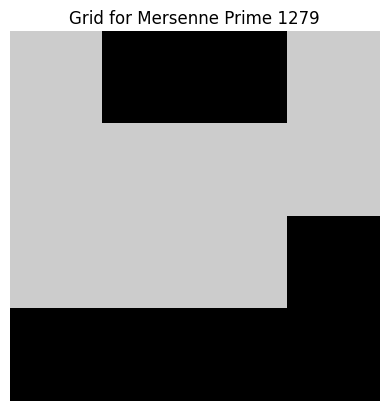

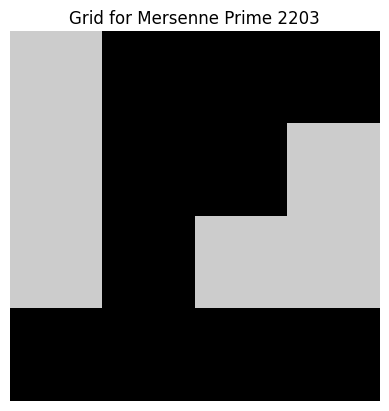

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict

# Example known data for Mersenne primes and perfect numbers
known_mersenne_primes = [2, 3, 5, 7, 13, 17, 19, 31, 61, 89, 107, 127, 521, 607, 1279, 2203]
known_perfect_numbers = [(2**(p - 1)) * (2**p - 1) for p in known_mersenne_primes]

# Convert task ID or number to hexadecimal color for visualization
def number_to_hex_color(number):
    hex_str = f"{hex(number)[2:]:0>6}"  # Ensure it's 6 characters
    return f"#{hex_str[:6]}"

# Function to create graph from known numbers with color coding based on hex representation
def create_graph(numbers):
    G = nx.Graph()
    for idx, num in enumerate(numbers):
        # Convert the number to hex color for the node representation
        hex_color = number_to_hex_color(num)
        G.add_node(idx, value=num, color=hex_color)

        # Connect each node to the previous node to show progression
        if idx > 0:
            G.add_edge(idx - 1, idx)

    return G

import matplotlib.pyplot as plt

# Updated function to visualize the graph with color-coding based on hexadecimal representation
def visualize_graph(G, title="Number Graph"):
    pos = nx.spring_layout(G, seed=42)
    node_colors = [G.nodes[node]["color"] for node in G.nodes()]
    labels = {node: f"{G.nodes[node]['value']}\n{G.nodes[node]['color']}" for node in G.nodes()}

    fig, ax = plt.subplots(figsize=(10, 8))  # Explicitly create a figure and axis
    nx.draw(
        G, pos, labels=labels, node_color=node_colors, node_size=500, edgecolors="black", ax=ax
    )
    ax.set_title(title)
    plt.show()

# Extract transformation patterns between numbers
def extract_patterns(numbers):
    patterns = defaultdict(list)
    for i in range(1, len(numbers)):
        # Calculate differences and ratios as potential patterns
        diff = numbers[i] - numbers[i - 1]
        ratio = numbers[i] / numbers[i - 1] if numbers[i - 1] != 0 else None
        patterns["difference"].append(diff)
        patterns["ratio"].append(ratio)

    return patterns

# Define a simple neural network model to learn from patterns
class PatternModel(nn.Module):
    def __init__(self):
        super(PatternModel, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train the model on the extracted patterns
def train_model(model, patterns, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Prepare data for training: differences and ratios
    differences = torch.tensor(patterns["difference"], dtype=torch.float32).unsqueeze(1)
    ratios = torch.tensor(patterns["ratio"], dtype=torch.float32).unsqueeze(1)
    inputs = torch.cat((differences, ratios), dim=1)[:-1]
    targets = differences[1:]  # Predict next difference

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

    return model

# Predict the next number based on the last observed difference and ratio
def predict_next_number(model, last_difference, last_ratio):
    model.eval()
    with torch.no_grad():
        input_data = torch.tensor([[last_difference, last_ratio]], dtype=torch.float32)
        next_difference = model(input_data).item()
    return next_difference

# Visualize grids based on numbers, simulating ARC-like grid representation
def visualize_grid(grid, title="Number Grid"):
    plt.imshow(grid, cmap="nipy_spectral", interpolation="nearest")
    plt.title(title)
    plt.axis("off")
    plt.show()

def number_to_grid(number):
    binary_str = bin(number)[2:]
    grid_size = int(np.ceil(np.sqrt(len(binary_str))))
    grid = np.zeros((grid_size, grid_size), dtype=int)
    for idx, bit in enumerate(binary_str):
        grid[idx // grid_size][idx % grid_size] = int(bit)
    return grid

# Main function to run the updated process
def main():
    # Step 1: Create a graph for known Mersenne primes
    G = create_graph(known_mersenne_primes)
    visualize_graph(G, title="Mersenne Primes Graph")
    
    # Step 2: Extract transformation patterns
    patterns = extract_patterns(known_mersenne_primes)
    print("Extracted Patterns:", patterns)
    
    # Step 3: Train the model on the extracted patterns
    model = PatternModel()
    model = train_model(model, patterns, epochs=50)

    # Step 4: Predict the next number
    last_difference = patterns["difference"][-1]
    last_ratio = patterns["ratio"][-1]
    next_difference = predict_next_number(model, last_difference, last_ratio)
    predicted_next_prime = known_mersenne_primes[-1] + next_difference
    print("Predicted Next Mersenne Prime (Approx):", int(predicted_next_prime))

    # Step 5: Visualize the grid representation of each Mersenne prime
    for num in known_mersenne_primes:
        grid = number_to_grid(num)
        visualize_grid(grid, title=f"Grid for Mersenne Prime {num}")

if __name__ == "__main__":
    main()